In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from Adversary import Adversary, Problem
from Solvers import adv_solver, partial, span_solver
from Examples import threshold_k
from ElementDistinctness import ED
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =200
import cvxpy as cp
from cvxpy.atoms.affine.hstack import hstack
from cvxpy.atoms.affine.vstack import vstack

In [2]:
n = 4
k = 2
prob = threshold_k(n, k)


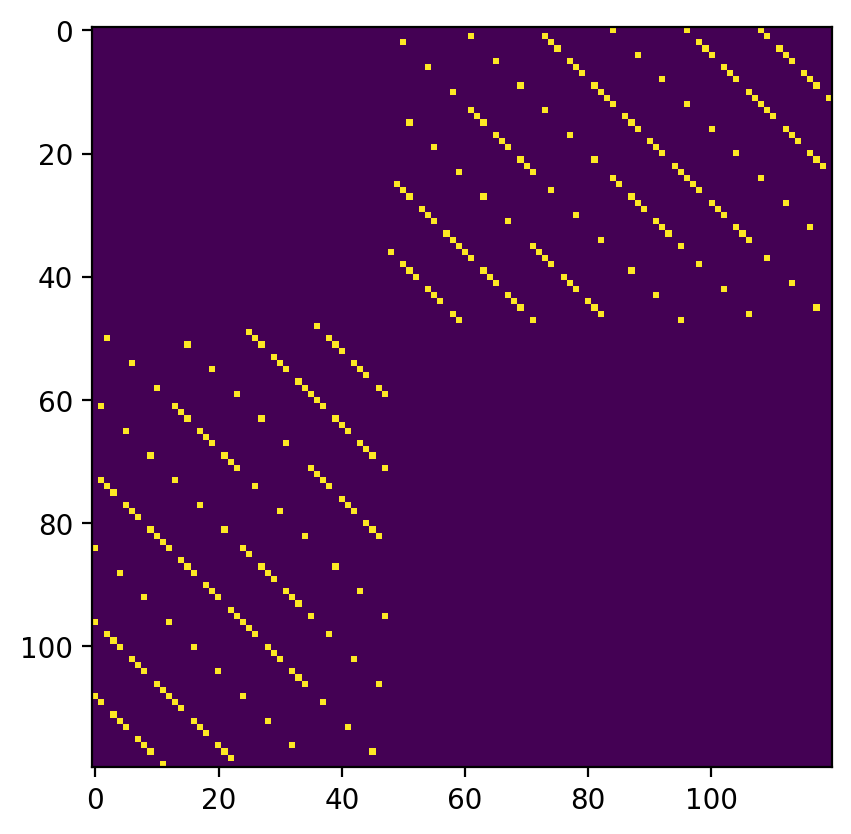

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 31 03:27:44 PM: Your problem has 14400 variables, 24 constraints, and 0 parameters.
(CVXPY) Jul 31 03:27:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 31 03:27:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 31 03:27:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 31 03:27:44 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 31 03:27:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [11]:
def disagree_mask(problem, yes, no, d,  mat_size):
    # yes = problem.yes_instances[yes_index]
    # no = problem.no_instancesl[no_index]
    yes_index = problem.instance_to_index[yes]
    no_index = problem.instance_to_index[no]
    mask = []
    pair_mat = np.zeros((n, n))
    for i in range(n):
        if yes[i] != no[i]:
            pair_mat[i,i]= 1
    pair_mat = np.kron(np.eye(d), pair_mat)
    for i in range(problem.len):
        mask.append([
            np.zeros((n*d, n*d)) if i != no_index or j != yes_index else pair_mat for j in range(problem.len)
        ])
        
    mask = np.block(mask)
    return mask + mask.T

def diag_mask(problem, instance, d, mat_size):
    instance_mask = np.eye(problem.n * d)
    mask = np.zeros((problem.len, problem.len))
    index = problem.instance_to_index[instance]
    mask[index][index] = 1
    mask = np.kron(mask, instance_mask)
    return mask + mask.T

def diag_vect(problem, instance, d, mat_size):
    instance_mask = np.ones((problem.n * d, 1))
    instance_vect = np.zeros((problem.len, 1))
    instance_vect[problem.instance_to_index[instance]] = 1
    return np.kron(instance_vect, instance_mask)

def bmat(block_lists):
    """Constructs a block matrix.

    Takes a list of lists. Each internal list is stacked horizontally.
    The internal lists are stacked vertically.

    Parameters
    ----------
    block_lists : list of lists
        The blocks of the block matrix.

    Return
    ------
    CVXPY expression
        The CVXPY expression representing the block matrix.
    """
    row_blocks = [hstack(blocks) for blocks in block_lists]
    return vstack(row_blocks)

def space_span_solver(problem, d):
    lang_size = problem.yes_len + problem.no_len
    n = problem.n
    mat_size = lang_size * n * d 
    P = cp.Variable((mat_size, mat_size), PSD=True)
    t = cp.Variable()
    # x = cp.Variable((mat_size, 1))
    
    constraints = []
    
    for yes in problem.yes_instances:
        for no in problem.no_instances:
          
            constraints += [
                cp.sum(cp.multiply(disagree_mask(problem, yes, no, d, mat_size), P)) == 1 
            ]
    
    # for instance in problem.instances:
        # constraints += [
            # cp.sum(cp.multiply(diag_mask(problem, instance, d, mat_size), P)) <= t
        # ]
        
#     print( bmat([[P, x],
#              [x.T, np.array([[1]])]]))
#     constraints += [
#         bmat([[P, x],
#              [x.T, np.array([[1]])]]) >> 0
#     ]
    
    
    opt_prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints)
    opt_prob.solve(solver='SCS', verbose=True)
    return opt_prob.value, P.value

d = 3
mat_size = prob.len * n * d
mask = np.zeros((mat_size, mat_size))
for no in prob.no_instances:
    for yes in prob.yes_instances:
        mask += disagree_mask(prob, yes, no, d, mat_size)
plt.imshow(mask)
plt.show()
v, P = space_span_solver(prob, d)
v, X = span_solver(prob)

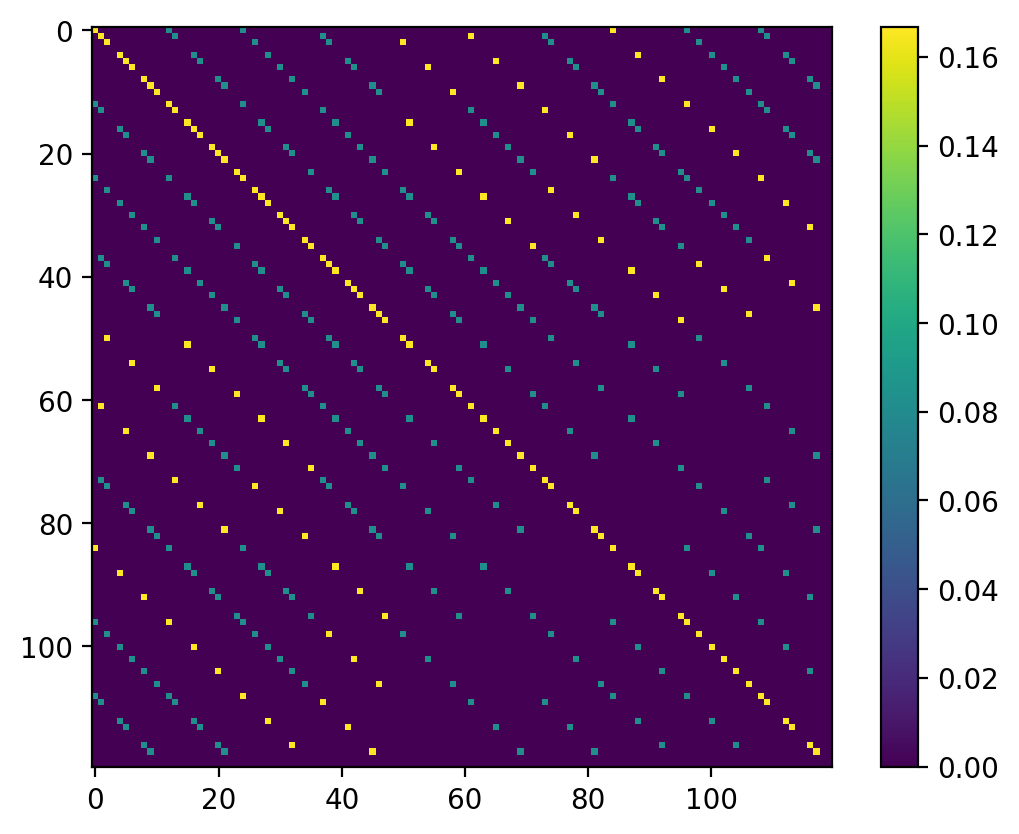

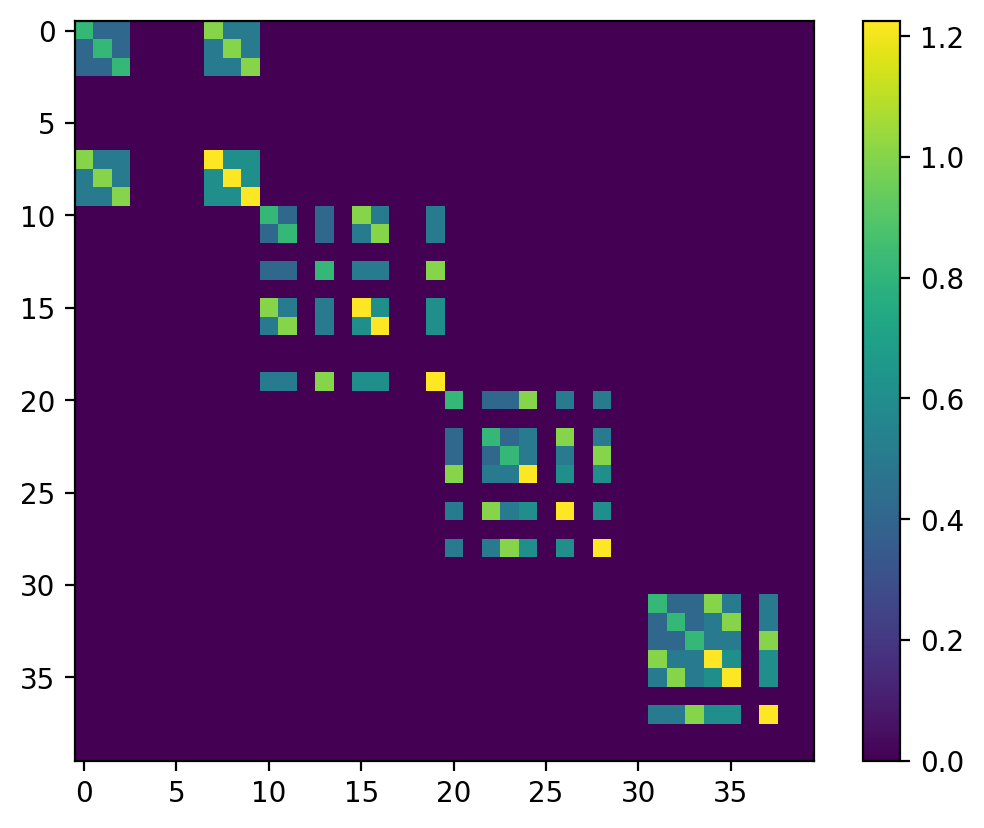

{0.1666670608, 0.0, 0.083333036, 0.1666666668, 0.0833332342, 1.982e-07, 8.26e-08}
36


In [12]:
plt.imshow(P)
plt.colorbar()
plt.show()
plt.imshow(X)
plt.colorbar()
plt.show()
print(set(np.round(P.flatten(), 10)))
print(np.linalg.matrix_rank(np.round(P, 6)))